# Detailed Demo: SHAP Values with LightGBM on UCI Bank Dataset

Make sure you have the latest versions to avoid version mismatches when computing SHAP values

In [26]:
pip install --upgrade numpy shap lightgbm

  Using cached numpy-2.2.4-cp310-cp310-macosx_11_0_arm64.whl (14.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

## Load and Preprocess the Dataset


In [11]:
# Read data and drop highly correlated column 'duration'
bank_data = pd.read_csv("uci_bank_data.csv")
bank_data.drop(columns=['duration'], inplace=True)

# Encode target values as 0/1 and drop original 'y' column
bank_data['target'] = bank_data['y'].map({'no': 0, 'yes': 1})
bank_data.drop(columns=['y'], inplace=True)

# Identify and change data type of categorical variables
categorical_variables = bank_data.select_dtypes(exclude=np.number).columns.tolist()

for col in categorical_variables:
    bank_data[col] = bank_data[col].astype('category')

bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  int64   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  category
 5   balance    45211 non-null  int64   
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  int64   
 10  month      45211 non-null  category
 11  campaign   45211 non-null  int64   
 12  pdays      45211 non-null  int64   
 13  previous   45211 non-null  int64   
 14  poutcome   45211 non-null  category
 15  target     45211 non-null  int64   
dtypes: category(9), int64(7)
memory usage: 2.8 MB


## Train a LightGBM Model 

In [12]:
# Split the data into features and target
X = bank_data.drop('target', axis=1)
y = bank_data['target']

# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Train classifier
lgbm_clf = lgb.LGBMClassifier(random_state=42)
lgbm_clf.fit(X_train, y_train, categorical_feature=categorical_variables)

# Generate predictions
y_pred = lgbm_clf.predict(X_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Evaluation Metrics:")
print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

[LightGBM] [Info] Number of positive: 3702, number of negative: 27945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 31647, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116978 -> initscore=-2.021365
[LightGBM] [Info] Start training from score -2.021365
Evaluation Metrics:
Accuracy: 0.8967
Precision: 0.6467
Recall: 0.2583
F1 Score: 0.3692


Can ignore this warning. Newer versions of the SHAP library return a list of ndarrays - we will observe and use the data type returned

Ignore the warning - this represents a change in how the SHAP values are returned

In [13]:
explainer = shap.TreeExplainer(lgbm_clf.booster_)

shap_values = explainer.shap_values(X_train)

/Users/vitthalsrinivasan/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Interpretation of the Shape (31647, 15):

31647: This number represents the number of samples in your X_train data that you passed to the explainer.shap_values() function. For each row (instance) in your training data, SHAP calculates a set of feature contribution values.

15: This number represents the number of features in your X_train data (and the model you trained). For each of the 31647 samples, SHAP has calculated a contribution score for each of the 15 features.

In [14]:
shap_values.shape

(31647, 15)

SHAP values for a particular instance in our training data

In [15]:
shap_values[:1]

array([[-5.62574972e-03, -4.08055721e-02, -1.58550290e-01,
         1.29210471e-02, -1.52572460e-04, -3.12293518e-01,
        -7.17706827e-02,  1.89137241e-02,  2.38282456e-01,
         4.95176591e-02, -1.76386081e-01, -2.66776896e-02,
         8.99827149e-03, -2.22984055e-02, -9.33208011e-02]])

In [16]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)

shap_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean_Absolute_SHAP': mean_abs_shap,
    'LightGBM_Importance': lgbm_clf.booster_.feature_importance()
}).sort_values(by='Mean_Absolute_SHAP', ascending=False)

shap_importance

,Feature,Mean_Absolute_SHAP,LightGBM_Importance
8,contact,0.393477,84
10,month,0.311655,242
5,balance,0.156861,631
2,marital,0.154944,131
14,poutcome,0.154473,41
9,day,0.142483,528
6,housing,0.114972,63
0,age,0.101268,479
11,campaign,0.093203,198
12,pdays,0.063930,331


## Generate SHAP Summary Plot

The SHAP summary plot visualizes overall feature importance and the impact (magnitude and direction) of each feature on the model predictions.

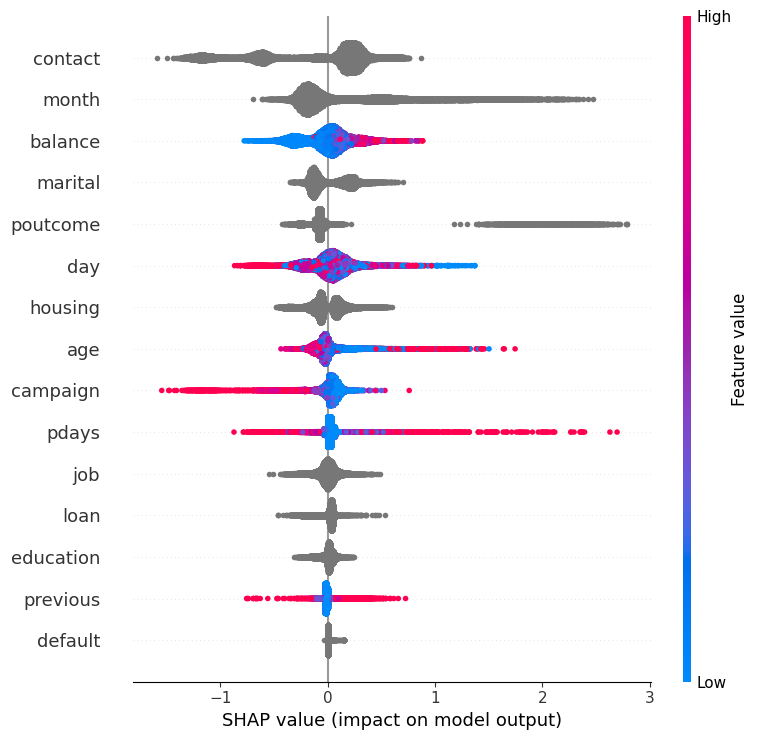

In [17]:
shap.summary_plot(shap_values, X_train)

## Generate SHAP Dependence Plot

A SHAP dependence plot shows how the SHAP value of a feature varies with its value and can reveal feature interactions. 
Below, we generate a dependence plot for the feature **balance**.

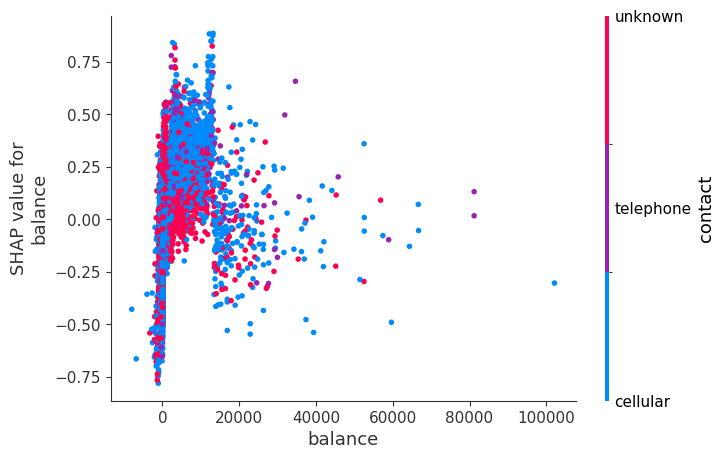

In [18]:
shap.dependence_plot('balance', shap_values, X_train)

## Generate SHAP Waterfall Plot

The SHAP waterfall plot breaks down an individual prediction into feature contributions, showing how each feature adds or subtracts from the model's expected output. 

Below, we generate a waterfall plot for the first instance in the training set.

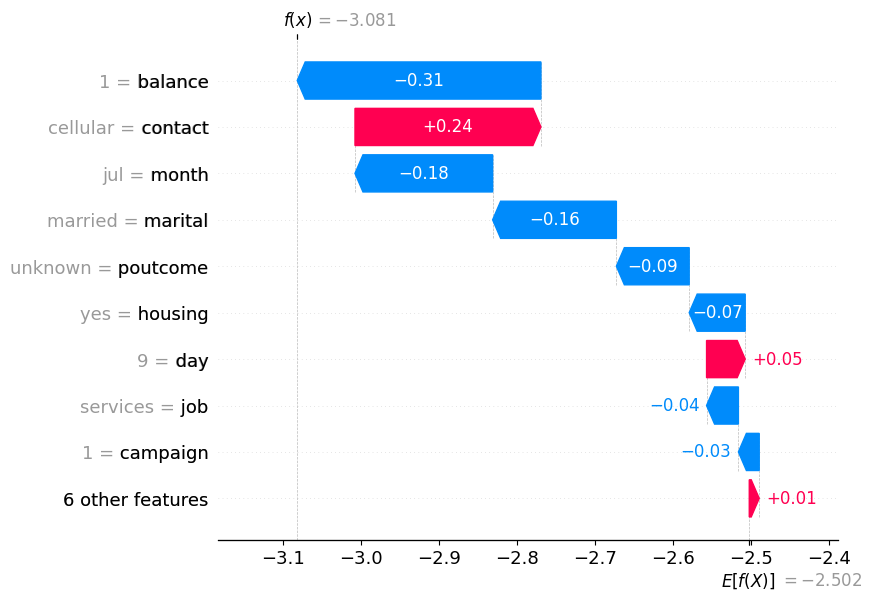

In [19]:
shap.waterfall_plot(shap.Explanation(
    values=shap_values[0], base_values=explainer.expected_value, data=X_train.iloc[0]))